<a href="https://colab.research.google.com/github/Samy-OUABID/IAE-METZ-Samy-Yassin/blob/main/Examen_mod%C3%A9lisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [48]:
# Définition des fonds Small Caps
funds_Small_FRA = ["0P0000L1MW.F"]  # Fonds Small caps français
funds_Small_LUX = ["0P0001D3JX.F"]  # Fonds Small caps Luxembourgeois
benchmark = "DJSC.L"  # Benchmark Small Caps Europe


In [54]:
# Liste complète des fonds à récupérer
all_funds = funds_Small_FRA + funds_Small_LUX + [benchmark]

# Téléchargement des données sur 5 ans
fund_data = yf.download(all_funds, start="2023-01-01", end="2025-01-01")['Close']

# Vérification des données
print("\nAperçu des prix des fonds :")
print(fund_data.head())

[*********************100%***********************]  3 of 3 completed



Aperçu des prix des fonds :
Ticker      0P0000L1MW.F  0P0001D3JX.F       DJSC.L
Date                                               
2023-01-02    261.510010     36.180000          NaN
2023-01-03    266.790009     36.020000  3560.048096
2023-01-04    267.489990     36.389999  3610.773682
2023-01-05    269.510010     36.820000  3626.766357
2023-01-06    268.230011     36.790001  3646.756592


In [55]:
# Calcul des rendements quotidiens
fund_returns = fund_data.pct_change().dropna()

# Calcul des rendements cumulés
cumulative_returns = (1 + fund_returns).cumprod() - 1


<ipython-input-55-71e2f375fced>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fund_returns = fund_data.pct_change().dropna()


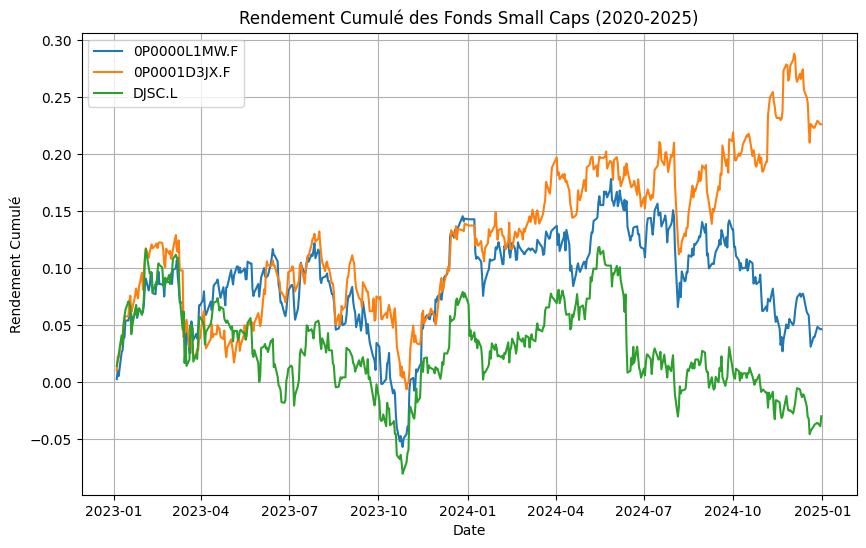

In [56]:
# Affichage des rendements cumulés
plt.figure(figsize=(10, 6))
for fund in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[fund], label=fund)
plt.title("Rendement Cumulé des Fonds Small Caps (2020-2025)")
plt.xlabel("Date")
plt.ylabel("Rendement Cumulé")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# ---- Calcul des indicateurs de rentabilité ----
annual_returns = fund_returns.mean() * 252
annual_volatility = fund_returns.std() * np.sqrt(252)
sharpe_ratio = annual_returns / annual_volatility

In [58]:
# ---- Séparation des fonds ----
small_caps_funds = funds_Small_FRA + funds_Small_LUX
benchmark_fund = [benchmark]

In [59]:
# Indicateurs Small Caps
small_caps_indicators = pd.DataFrame({
    'Rendement Annuel': annual_returns[small_caps_funds],
    'Volatilité Annuelle': annual_volatility[small_caps_funds],
    'Sharpe Ratio': sharpe_ratio[small_caps_funds]
}, index=small_caps_funds)


In [60]:
# Indicateurs Benchmark
benchmark_indicators = pd.DataFrame({
    'Rendement Annuel': annual_returns[benchmark_fund],
    'Volatilité Annuelle': annual_volatility[benchmark_fund],
    'Sharpe Ratio': sharpe_ratio[benchmark_fund]
}, index=benchmark_fund)


In [61]:
# Affichage des indicateurs
print("\nIndicateurs de Rentabilité des Fonds Small Caps :")
print(small_caps_indicators)

print("\nIndicateurs de Rentabilité du Benchmark :")
print(benchmark_indicators)


Indicateurs de Rentabilité des Fonds Small Caps :
              Rendement Annuel  Volatilité Annuelle  Sharpe Ratio
0P0000L1MW.F          0.032317             0.140373      0.230226
0P0001D3JX.F          0.111060             0.141756      0.783457

Indicateurs de Rentabilité du Benchmark :
        Rendement Annuel  Volatilité Annuelle  Sharpe Ratio
DJSC.L         -0.003964             0.148869     -0.026629


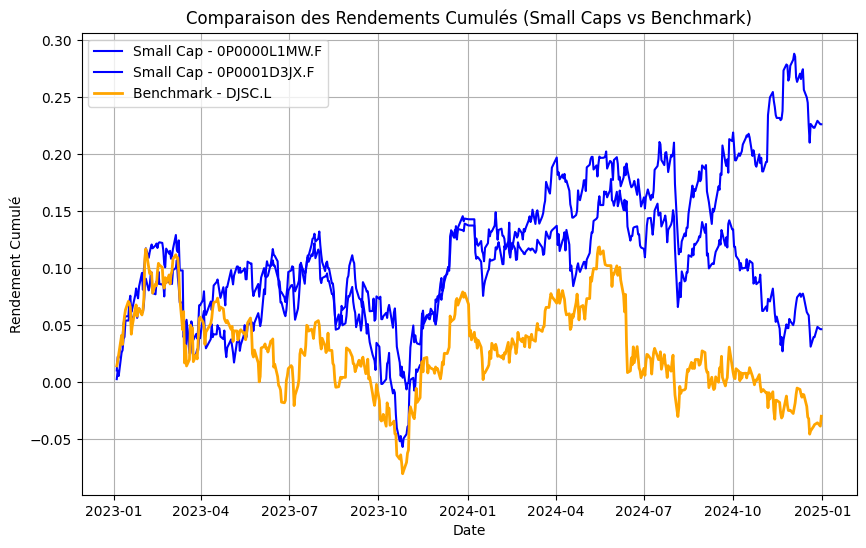

In [62]:
# ---- Comparaison visuelle ----
plt.figure(figsize=(10, 6))
for fund in small_caps_funds:
    plt.plot(cumulative_returns.index, cumulative_returns[fund], label=f"Small Cap - {fund}", color='blue')
plt.plot(cumulative_returns.index, cumulative_returns[benchmark], label=f"Benchmark - {benchmark}", color='orange', linewidth=2)
plt.title("Comparaison des Rendements Cumulés (Small Caps vs Benchmark)")
plt.xlabel("Date")
plt.ylabel("Rendement Cumulé")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
# ---- Calcul du Maximum Drawdown ----
def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

max_drawdowns = {fund: calculate_max_drawdown(cumulative_returns[fund]) for fund in cumulative_returns.columns}
print("\nMaximum Drawdown des fonds :", max_drawdowns)



Maximum Drawdown des fonds : {'0P0000L1MW.F': -1.4666263645383972, '0P0001D3JX.F': -1.0483192486005377, 'DJSC.L': -1.6877718738722387}


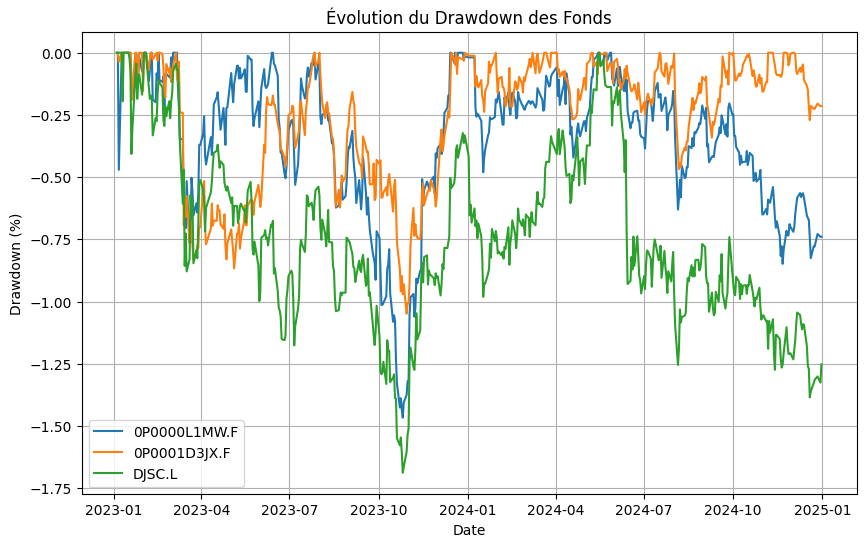

In [64]:
plt.figure(figsize=(10, 6))
for fund in cumulative_returns.columns:
    peak = cumulative_returns[fund].cummax()
    drawdown = (cumulative_returns[fund] - peak) / peak
    plt.plot(drawdown, label=f"{fund}")

plt.title("Évolution du Drawdown des Fonds")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()


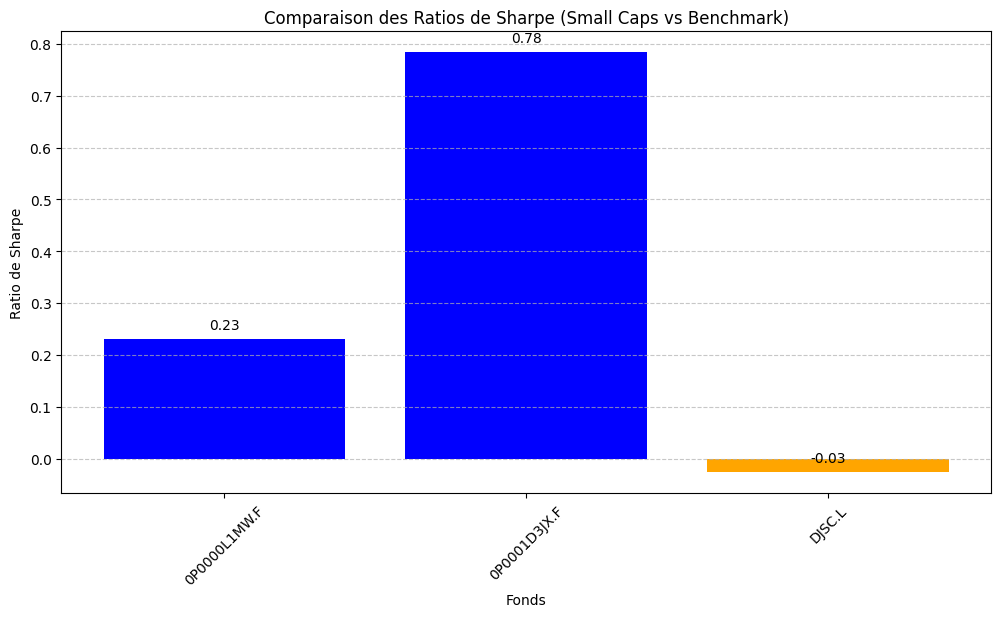

In [69]:
# ---- Affichage de la comparaison des Ratios de Sharpe ----

plt.figure(figsize=(12, 6))

# Création d'un DataFrame pour la comparaison
sharpe_df = pd.DataFrame({
    'Fonds': small_caps_funds + [benchmark],
    'Sharpe Ratio': [sharpe_ratio[fund] for fund in small_caps_funds + [benchmark]]
})

# Tracé du graphique en barres
plt.bar(sharpe_df['Fonds'], sharpe_df['Sharpe Ratio'], color=['blue'] * len(small_caps_funds) + ['orange'])

# Ajouter des labels
plt.title("Comparaison des Ratios de Sharpe (Small Caps vs Benchmark)")
plt.ylabel("Ratio de Sharpe")
plt.xlabel("Fonds")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage des valeurs sur les barres
for index, value in enumerate(sharpe_df['Sharpe Ratio']):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.show()
